In [1]:
import os
from skimage import io, transform
import numpy as np
import tensorflow as tf
from matplotlib import image
import matplotlib.pyplot as plt
import random
plt.rcParams['figure.figsize'] = [12,8]

In [ ]:
tf.reset_default_graph()

x_dim, z_dim = 64, 100
z = tf.placeholder(tf.float32, [1,z_dim], "z")
x = tf.placeholder(tf.float32, [1,x_dim,x_dim,3], "x")

def Generator(z):
    with tf.variable_scope("generator") as scope:
        fc0 = tf.layers.dense(z, 16384, tf.nn.relu,
                              kernel_initializer=tf.contrib.layers.variance_scaling_initializer(), name="fc0")
        fcInput = tf.reshape(fc0, [1,4,4,1024])
        gl1 = tf.layers.conv2d_transpose(fcInput, 512, 5, (2, 2), 'SAME',
                                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                         activation=tf.nn.relu, name="gl1")
        gl2 = tf.layers.conv2d_transpose(gl1, 256, 5, (2, 2), 'SAME',
                                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                         activation=tf.nn.relu, name="gl2")
        gl3 = tf.layers.conv2d_transpose(gl2, 128, 5, (2, 2), 'SAME',
                                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                         activation=tf.nn.relu, name="gl3")
        gl4 = tf.layers.conv2d_transpose(gl3, 3, 5, (2, 2), 'SAME',
                                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                         activation=tf.nn.sigmoid, name="gl4")
        return gl4

a = 0.2
leaky_relu = lambda x:  tf.maximum(a*x, x)

def Discriminator(imgs, reuse=False):
    with tf.variable_scope("discriminator") as scope:
        conv1 = tf.layers.conv2d(imgs, 128, 5, (2, 2), 'SAME',
                                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                 activation=leaky_relu, reuse=reuse, name="conv1")
        conv2 = tf.layers.conv2d(conv1, 256, 5, (2, 2), 'SAME',
                                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                 activation=leaky_relu, reuse=reuse, name="conv2")
        conv3 = tf.layers.conv2d(conv2, 512, 5, (2, 2), 'SAME',
                                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                 activation=leaky_relu, reuse=reuse, name="conv3")
        conv4 = tf.layers.conv2d(conv3, 1024, 5, (2, 2), 'SAME',
                                 kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                 activation=leaky_relu, reuse=reuse, name="conv4")
        conv4_reshape = tf.reshape(conv4, [1, 16384])
        fc5 = tf.layers.dense(conv4_reshape, 1, 
                              kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                              reuse=reuse, name="fc5")
        return fc5

In [ ]:
with tf.name_scope("WGAN") as scope:
    lam = 10
    x_out = Discriminator(x)
    x_twiddle = Generator(z)
    x_twiddle_out = Discriminator(x_twiddle, True)

    with tf.name_scope("generator_loss") as scope:
        g_loss = -tf.reduce_mean(x_twiddle_out)

    with tf.name_scope("discriminator_loss") as scope:
        e = tf.random_uniform(shape=x_twiddle.shape, minval=0., maxval=1.)
        x_hat = e*x + (1.-e)*x_twiddle
        x_hat_out = Discriminator(x_hat, True)
        gradients = tf.gradients(x_hat_out, [x_hat])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients)))
        d_loss = x_twiddle_out - x_out
        gradient_penalty = (slopes-1.)**2
        d_loss = tf.reduce_mean(d_loss + lam*gradient_penalty)

    d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
    g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

    alpha, beta1, beta2 = 2e-4, 0.5, 0.999
    disc_train = tf.train.AdamOptimizer(alpha, beta1=beta1, beta2=beta2).minimize(d_loss, var_list=d_vars)
    gen_train = tf.train.AdamOptimizer(alpha, beta1=beta1, beta2=beta2).minimize(g_loss, var_list=g_vars)

init = tf.global_variables_initializer()

files = os.listdir('img_align_celeba')
epochs, mod = 5, 500

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    for j in xrange(epochs):
        g_loss_li, d_loss_li = [],[]
        for i, name in enumerate(files[:100000]):
            noise = np.random.rand(z_dim).reshape((1,z_dim)).astype(np.float32)
            img = transform.resize(io.imread('img_align_celeba/' + name), (x_dim,x_dim,3), mode='constant')
            img = np.reshape(img, [1, x_dim, x_dim, 3])
            gl, dl, _, _, gen_img = sess.run([g_loss, d_loss, gen_train, disc_train, x_twiddle],
                                               feed_dict={z:noise, x:img})
            gen_img = np.reshape(gen_img, (x_dim,x_dim,3))
            if (i+1) % mod == 0:
                saver.save(sess, "checkpoints/model"+str(j)+'_'+str(i+1)+'.ckpt')
                image.imsave('images/gen_img'+str(j)+'_'+str(i+1)+'.png', gen_img)
                print("GENERATOR LOSS: {}\tDISCRIMINATOR LOSS: {}".format(np.mean(g_loss_li), np.mean(d_loss_li)))
            g_loss_li.append(gl)
            d_loss_li.append(dl)

    # interpolation
    z1 = np.random.rand(z_dim).reshape((1,z_dim)).astype(np.float32)
    z9 = np.random.rand(z_dim).reshape((1,z_dim)).astype(np.float32)
    z5 = np.mean([z1,z9], axis=0)
    z3 = np.mean([z1,z5], axis=0)
    z7 = np.mean([z5,z9], axis=0)
    z2 = np.mean([z1,z3], axis=0)
    z4 = np.mean([z3,z5], axis=0)
    z6 = np.mean([z5,z7], axis=0)
    z8 = np.mean([z7,z9], axis=0)
    for i,noise in enumerate([z1, z2, z3, z4, z5, z6, z7, z8, z9]):
        gen_img = sess.run([x_twiddle], feed_dict={z:noise, x:img})
        gen_img = np.reshape(gen_img, (x_dim,x_dim,3))
        image.imsave('images/interpolation/z'+str(i)+'.png', gen_img)

## Some Generated Images

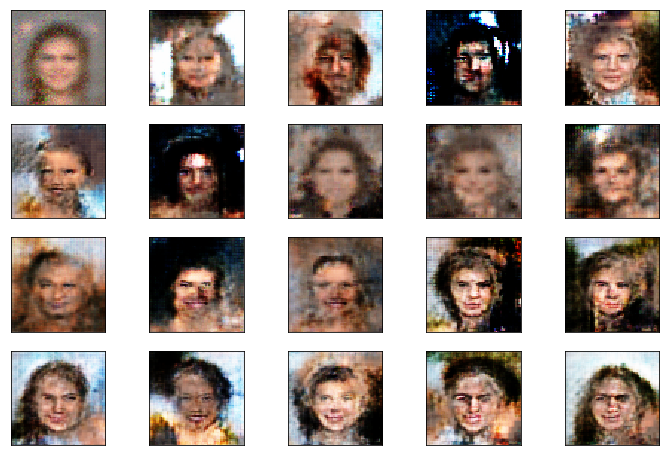

In [2]:
imgs = ["test_img0_1000_2", "test_img0_35500", "test_img0_52500", "test_img0_67500",
       "test_img3_91500", "test_img3_72500", "test_img0_68500", "test_img0_92000",
       "test_img0_93500", "test_img1_500", "test_img1_27500", "test_img1_68000",
       "test_img1_71500", "test_img2_80500", "test_img2_95000", "test_img3_37500",
       "test_img3_44500", "test_img3_62000", "test_img3_79500", "test_img3_80000"]
for i,f in enumerate(imgs):
    plt.subplot(4,5,i+1)
    img = plt.imread("out_imgs/goodish_faces/" + f + ".png")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

## Z-Space Interpolation

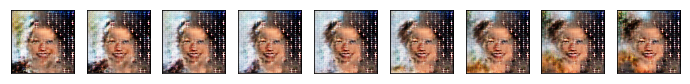

In [3]:
for i,f in enumerate(os.listdir("out_imgs/outputs_success1/interpolation/")):
    plt.subplot(1,9,i+1)
    plt.xticks([])
    plt.yticks([])
    img = plt.imread("out_imgs/outputs_success1/interpolation/" + f)
    plt.imshow(img)
plt.show()